<a href="https://colab.research.google.com/github/bonsii2/Abugida-Robotics/blob/main/eyeDiseaseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q opencv-python-headless pillow scikit-learn matplotlib seaborn kaggle
import tensorflow as tf
print('install complete. tensorflow version:', tf.__version__)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install kaggle package
!pip install -q kaggle

# Make folder for kaggle key
!mkdir -p ~/.kaggle

# Move kaggle.json to the right location
!cp kaggle.json ~/.kaggle/

# Give correct permissions
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API key setup complete.")


Kaggle API key setup complete.


In [5]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
ocular-disease-recognition-odir5k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!mkdir odir5k

In [ ]:
!unzip ocular-disease-recognition-odir5k.zip -d odir5k/

In [8]:
import pandas as pd

df = pd.read_csv('/content/odir5k/full_df.csv')
df.head()


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [13]:
# Fix base path
df['filepath'] = df['filepath'].str.replace(
    r'\.\./input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images',
    '/content/odir5k/ODIR-5K/ODIR-5K/Training Images',
    regex=True
)

df['filepath'] = df['filepath'].str.replace(
    r'\.\./input/ocular-disease-recognition-odir5k/ODIR-5K/Testing Images',
    '/content/odir5k/ODIR-5K/ODIR-5K/Testing Images',
    regex=True
)


In [14]:
import os
path = df['filepath'].iloc[0]
print(path)
print(os.path.exists(path))


/content/odir5k/ODIR-5K/ODIR-5K/Training Images/0_right.jpg
True


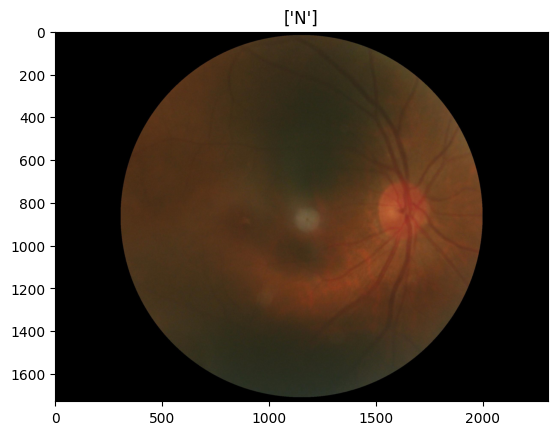

In [15]:
import cv2
import matplotlib.pyplot as plt

# take the first sample
path = df['filepath'].iloc[0]

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(df['labels'].iloc[0])
plt.show()


In [16]:
import numpy as np
import pandas as pd

# ensure df is the dataframe you loaded earlier
print("rows:", len(df))

# Confirm 'target' column is a string like "[1, 0, 0, ...]" or list
# If it's a string, we convert to actual list
def parse_target(x):
    if isinstance(x, str):
        # remove whitespace and convert to list of ints
        s = x.strip()
        # remove brackets if present
        s = s.strip('[]')
        parts = [p.strip() for p in s.split(',') if p.strip()!='']
        return [int(p) for p in parts]
    elif isinstance(x, (list, np.ndarray)):
        return list(x)
    else:
        raise ValueError("Unknown target type:", type(x))

df['target_vec'] = df['target'].apply(parse_target)

# quick sanity checks
print("Example target_vec:", df['target_vec'].iloc[0])
print("unique lengths:", df['target_vec'].apply(len).unique())

# convert to numpy array column for faster indexing later
df['target_arr'] = df['target_vec'].apply(lambda x: np.array(x, dtype=np.float32))

# show first few rows
df[['ID','filename','labels','target_vec']].head()


rows: 6392
Example target_vec: [1, 0, 0, 0, 0, 0, 0, 0]
unique lengths: [8]


,ID,filename,labels,target_vec
0,0,0_right.jpg,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]"
1,1,1_right.jpg,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]"
2,2,2_right.jpg,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]"
3,4,4_right.jpg,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]"
4,5,5_right.jpg,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]"


In [17]:
from sklearn.model_selection import GroupShuffleSplit

# set random seed for reproducibility
RANDOM_STATE = 42

# unique patient ids
patient_ids = df['ID'].unique()
print("unique patients:", len(patient_ids))

# first split: train vs temp (val+test)
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=RANDOM_STATE)
train_idx, temp_idx = next(gss.split(df, groups=df['ID']))
train_df = df.loc[train_idx].reset_index(drop=True)
temp_df = df.loc[temp_idx].reset_index(drop=True)

# second split: validation vs test from temp (split 50/50 of temp -> 10% val, 10% test)
gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=RANDOM_STATE)
val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df['ID']))
val_df = temp_df.loc[val_idx].reset_index(drop=True)
test_df = temp_df.loc[test_idx].reset_index(drop=True)

print("train rows:", len(train_df))
print("val rows:", len(val_df))
print("test rows:", len(test_df))

# quick class distribution check (sum of multi-labels)
print("Sum of labels (train):", np.sum(np.stack(train_df['target_arr'].values), axis=0))
print("Sum of labels (val):", np.sum(np.stack(val_df['target_arr'].values), axis=0))
print("Sum of labels (test):", np.sum(np.stack(test_df['target_arr'].values), axis=0))


unique patients: 3358
train rows: 5122
val rows: 637
test rows: 633
Sum of labels (train): [2293. 1310.  217.  232.  206.   99.  199.  566.]
Sum of labels (val): [325. 140.  30.  22.  31.  10.  11.  68.]
Sum of labels (test): [255. 158.  37.  39.  29.  19.  22.  74.]
